# Multitask Convolutional Neural Network
# 500 Bands

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output, Image
from tensorflow.compat.v1.keras import initializers
from keras.models import Model
from keras.layers import Input, GlobalMaxPooling1D, Activation, Concatenate
from keras.utils import plot_model

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from collections import Counter
from imblearn.over_sampling import SMOTE
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from sklearn.decomposition import PCA


import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D
#ICA
from sklearn.decomposition import FastICA

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import accuracy_score

In [2]:
from numpy.random import seed
seed(42)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(42)

Function to plot loss at callback while training.

In [3]:
class PlotProgress(Callback):
    
    def __init__(self, entity=['loss']):
        self.entity = entity

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('{}'.format(self.entity)))
        self.val_losses.append(logs.get('val_{}'.format(self.entity)))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="{}".format(self.entity))
        plt.plot(self.x, self.val_losses, label="val_{}".format(self.entity))
        plt.legend()
        plt.show();

## Dataset

In [4]:
df = pd.read_csv('../data/GHISACONUS_2008_small.csv')
df.dropna(axis = 1, how = 'all', inplace= True)
df = df[df['Stage'] != 'Harvest']
df['Label'] = [','.join(i) for i in zip(df["Crop"],df["Stage"])]

features = [col for col in df.columns if col.startswith('X')]
X = df[features]
z = df['Label']
c = df['Crop']
s = df['Stage']

In [5]:
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.15, random_state = 1, stratify= z)

X_train, X_test, c_train, c_test = train_test_split(X, c, test_size = 0.15, random_state = 1, stratify= z)

X_train, X_test, s_train, s_test = train_test_split(X, s, test_size = 0.15, random_state = 1, stratify= z)

#Generate y_test
y_test_df = pd.DataFrame(z_test)

#split z_train and dummify
y_test_df[['Crop','Stage']] = y_test_df['Label'].str.split(',',expand=True)
crop_dummy = pd.get_dummies(y_test_df['Crop'], prefix= 'Ycrop_')
stage_dummy = pd.get_dummies(y_test_df['Stage'], prefix= 'Ystage_')

#add the dummies to the df
y_test_df = pd.concat([y_test_df,crop_dummy, stage_dummy], axis = 1)

target = [col for col in y_test_df.columns if col.startswith('Y')]
y_test = y_test_df[target]

In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
e_crop = LabelEncoder()
e_stage = LabelEncoder()
e_crop = e_crop.fit(c)
e_stage = e_stage.fit(s)
#encoded_j_train = encoder.transform(j_train)
#encoded_j_test = encoder.transform(j_test)
# convert integers to dummy variables (i.e. one hot encoded)
#j_train = to_categorical(encoded_j_train)
#j_test = to_categorical(encoded_j_test)

In [8]:
#ICA
#transformer = FastICA(random_state = 42)
#Fitted_ICA = transformer.fit(X_train)
#X_test = Fitted_ICA.transform(X_test)

In [9]:
#PCA.
#pca = PCA(random_state = 42)
#pca.fit(X_train)
#X_test = pca.transform(X_test)

In [10]:
#SMOTE
oversample = SMOTE()
X_train, z_train = oversample.fit_resample(X_train, z_train)

# Transform ICA on the training data.
#X_train = Fitted_ICA.transform(X_train)
# OR Transform PCA on the training data.
#X_train = pca.transform(X_train)

In [11]:
#Generate y_test - NO SMOTE
y_train_df = pd.DataFrame(z_train)

#split z_train and dummify
y_train_df[['Crop','Stage']] = y_train_df['Label'].str.split(',',expand=True)
crop_dummy = pd.get_dummies(y_train_df['Crop'], prefix= 'Ycrop_')
stage_dummy = pd.get_dummies(y_train_df['Stage'], prefix= 'Ystage_')

#add the dummies to the df
y_train_df = pd.concat([y_train_df,crop_dummy, stage_dummy], axis = 1)

#target = [col for col in y_train_df.columns if col.startswith('Y')]
y_train = y_train_df[target]

## Data prep

In [12]:
#Dimensionality for CNN
Xs_train = np.expand_dims(X_train, axis=-1)
Xs_test = np.expand_dims(X_test, axis=-1)

In [13]:
#Split labels
Y_train, Y_train2 = np.split(y_train, np.arange(5, len(y_train.columns), 5), axis=1)[0], np.split(y_train, np.arange(5, len(y_train.columns), 5), axis=1)[0]
Y_test, Y_test2 = np.split(y_test, np.arange(5, len(y_test.columns), 5), axis=1)[0], np.split(y_test, np.arange(5, len(y_test.columns), 5), axis=1)[1]

In [14]:
print('Train')
print (Xs_train.shape, Y_train.shape, Y_train2.shape)
print('Test')
print(Xs_test.shape, Y_test.shape, Y_test2.shape)

Train
(14340, 50, 1) (14340, 5) (14340, 5)
Test
(1015, 50, 1) (1015, 5) (1015, 5)


## Model

In [152]:
filter_size = 3
maxpool_size = 2
dr = 0.25

inputs = Input(shape=(50, 1), name='main_input')

main_branch = Conv1D(64, kernel_size=filter_size, activation = 'relu')(inputs)
main_branch = MaxPooling1D(pool_size=maxpool_size)(main_branch)

main_branch = Conv1D(64, kernel_size=filter_size, activation = 'relu')(main_branch)
main_branch = MaxPooling1D(pool_size=maxpool_size)(main_branch)
#main_branch = Dropout(dr)(main_branch)

main_branch = Conv1D(128, kernel_size=filter_size, activation = 'relu')(main_branch)
main_branch = MaxPooling1D(pool_size=maxpool_size)(main_branch)
#main_branch = Dropout(dr)(main_branch)

main_branch = Conv1D(128, kernel_size=filter_size, activation = 'relu')(main_branch)
main_branch = MaxPooling1D(pool_size=maxpool_size)(main_branch)
#main_branch = Dropout(dr)(main_branch)

main_branch = Flatten()(main_branch)

#main_branch = Dense(128, activation = 'relu')(inputs)
#main_branch = Dropout(dr)(main_branch)
main_branch = Dense(256, activation = 'relu' )(main_branch)

main_branch = Dense(256, activation = 'relu' )(main_branch)
main_branch = Dropout(dr)(main_branch)

In [153]:
crop_branch = Dense(64, activation='relu', kernel_regularizer =l2( l=0.001))(main_branch)
crop_branch_m = Dense(16, activation='relu')(crop_branch)
crop_branch = Dense(5, activation='softmax', name='crop_output')(crop_branch_m)

In [154]:
stage_branch = Dense(64, activation='relu', kernel_regularizer =l1( l=0.0001))(main_branch)

stage_branch = Dense(128, activation='relu', kernel_regularizer =l1( l=0.1))(stage_branch)
stage_branch = Dropout(dr)(stage_branch)

stage_branch = Dense(64, activation='relu')(stage_branch)
stage_branch = Dense(16, activation='relu')(stage_branch)
#output
stage_branch = Dense(5, activation='softmax', name='stage_output')(stage_branch)

In [155]:
model = Model(inputs = inputs,
     outputs = [crop_branch, stage_branch])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 48, 64)       256         main_input[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 24, 64)       0           conv1d_34[0][0]                  
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 22, 64)       12352       max_pooling1d_33[0][0]           
___________________________________________________________________________________________

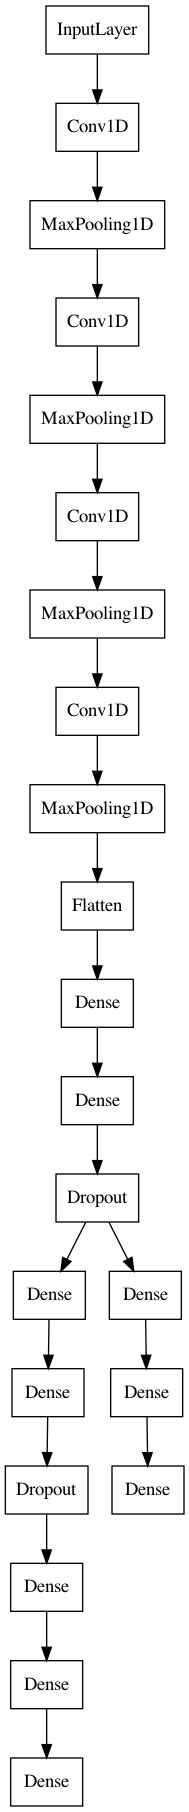

In [156]:
plot_model(model, show_layer_names=False)
Image(retina=True, filename='model.png')

In [157]:
opt = Adam
model.compile(optimizer='adam',
              loss={'crop_output': 'binary_crossentropy', 'stage_output': 'binary_crossentropy'},
              loss_weights={'crop_output': 0.01, 'stage_output': 0.1},
             metrics = {'crop_output': 'accuracy', 'stage_output': 'accuracy'})

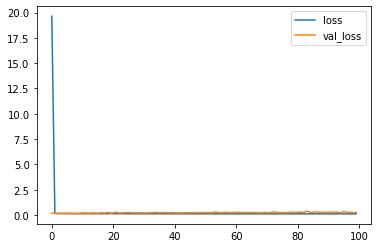

In [158]:
loss_progress = PlotProgress(entity='loss')

history = model.fit({'main_input': Xs_train},
              {'crop_output': Y_train, 'stage_output': Y_train2},
              epochs=100, batch_size=64,
              verbose=1,
              callbacks=[loss_progress],
              validation_data= ({'main_input': Xs_test}, {'crop_output': Y_test, 'stage_output': Y_test2})
             )

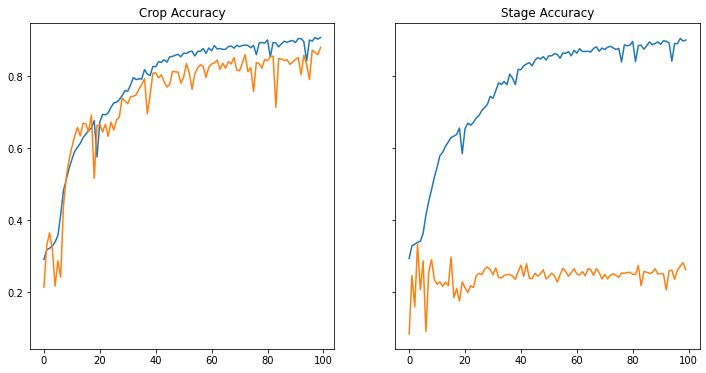

In [159]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[12,6], sharey='all')

#pyplot accuracy
ax1.plot(history.history['crop_output_accuracy'], label='Crop Accuracy')
ax1.plot(history.history['val_crop_output_accuracy'], label='Val Crop Accuracy')
ax1.set_title('Crop Accuracy');

#pyplot accuracy
ax2.plot(history.history['stage_output_accuracy'], label='Stage Accuracy')
ax2.plot(history.history['val_stage_output_accuracy'], label='Val Stage Accuracy')
ax2.set_title('Stage Accuracy');

## Analysis Results

In [160]:
pred_crops = pd.DataFrame(model.predict(Xs_test)[0])
pred_stages = pd.DataFrame(model.predict(Xs_test)[1])

crop_labels = ['Corn', 'Cotton', 'Rice', 'Soybean', 'Winter Wheat']
stage_labels = ['Critical', 'Early_Mid', 'Emerge_VEarly',  'Late', 'Mature_Senesc']

for i, col in enumerate(pred_crops):
        pred_crops.rename(columns={col: f'crop_{crop_labels[i]}'}, inplace=True)
        
for i, col in enumerate(pred_stages):
        pred_stages.rename(columns={col: f'stage_{stage_labels[i-4]}'}, inplace=True)


### Crop

In [161]:
for i in range(len(pred_crops)):
    for el in pred_crops.iloc[i]:
        row_max = pred_crops.iloc[i].max()
        pred_crops.iloc[i] = np.where(pred_crops.iloc[i] == row_max, 1, 0)

predictions = np.argmax(model.predict(Xs_test)[0], axis=-1)
prediction = np.argmax(to_categorical(predictions), axis = 1)
prediction = e_crop.inverse_transform(prediction)

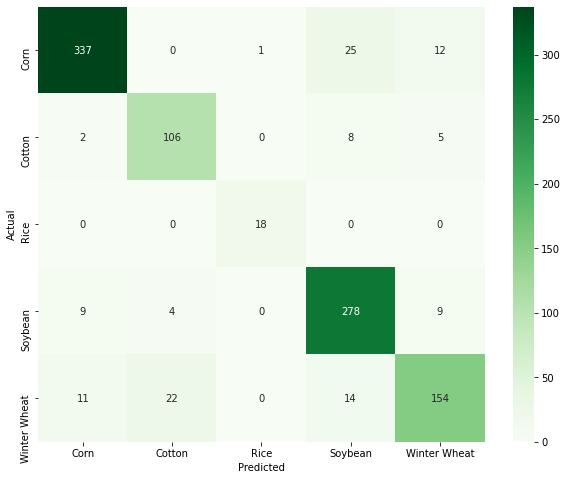

0.8798029556650246

In [162]:
conf_mat = confusion_matrix(c_test, prediction)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens',
            xticklabels=crop_labels, yticklabels=crop_labels, vmin = 0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
accuracy_score(c_test, prediction)

In [ ]:
cm = multilabel_confusion_matrix(c_test, prediction)

fig, grid_x = plt.subplots(nrows=3, ncols=2, figsize=(5*2,5*3)) 
grid_x = grid_x.flatten() 

for i in range(0, len(cm)):
    sns.heatmap(pd.DataFrame(cm[i]), annot = True, cmap = 'Greens', fmt = 'd', ax = grid_x[i], square=True)
    grid_x[i].set_title(f' Matrix For {crop_labels[i]}', fontsize =10)

### Stage

In [76]:
for i in range(len(pred_stages)):
    for el in pred_stages.iloc[i]:
        row_max = pred_stages.iloc[i].max()
        pred_stages.iloc[i] = np.where(pred_stages.iloc[i] == row_max, 1, 0)

predictions = np.argmax(model.predict(Xs_test)[0], axis=-1)
prediction = np.argmax(to_categorical(predictions), axis = 1)
prediction = e_stage.inverse_transform(prediction)

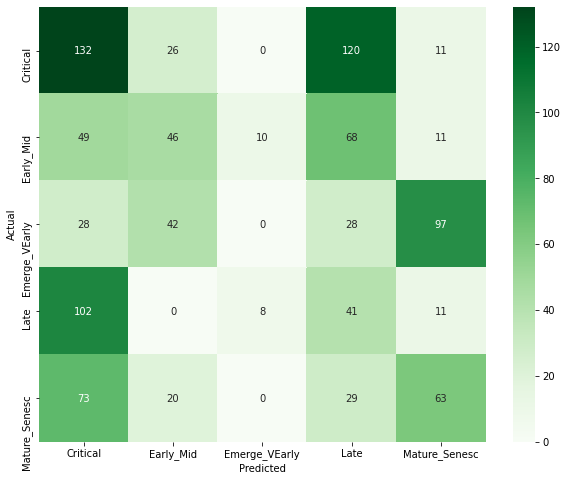

0.27783251231527095

In [114]:
conf_mat = confusion_matrix(s_test, prediction)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap= 'Greens',
            xticklabels=stage_labels, yticklabels=stage_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
accuracy_score(s_test, prediction)